In [1]:
from DataPreparation_python import * 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Your device : " + str(device))

# 제작한 Dataset으로부터 pairs 추출

Reading lines...
Read 199999 sentence pairs
Trimmed to 28557 sentence pairs
Counting words...
Counted words:
kor 35037
eng 12080
['나는 싱가포르에 사는 루이스라고 합니다 .', 'I m Louis who lives in Singapore .']
Your device : cuda


필자는 현재 NVIDIA RTX 3060 Ti를 사용해서, 프로젝트를 진행했고, CPU가 아닌 GPU를 이용하기 CUDA를 사용함을 언급하고자 한다. <br />
그리하여, 학습 과정에서도 CUDA를 사용한다는 전제하에 학습(train) 함수를 작성했다. <br />

<h3>Encoder & Decoder 제작</h3>

In [2]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Encoder 자체는 RNN과 매우 유사한 구조이다. RNN에 대한 자세한 설명은 생략하도록 하겠다. <br />
더 나은 퍼포먼스를 위하여 RNN 셀이 아닌 GRU 셀을 이용하였다. hidden state의 초기값은 torch.zeros를 이용하여 0으로 주었다.

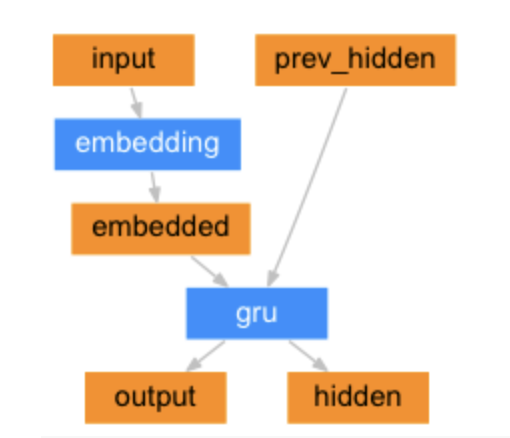

In [3]:
Image("img/encoder.png")

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        # what does .view(1, 1, -1) mean?
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Decoder 또한 GRU 셀을 이용하였고, 활성화 함수는 ReLU를 이용했다. <br />
이후에, 최종 ouput은 Softmax 함수를 이용하여, 다음에 올 확률이 가장 높은 단어를 선택할 수 있도록 한다. <br />
Encoder와 Decoder 둘 다 첨부한 사진을 토대로 코드와 비교하면서 보면 이해를 도울 수 있다. 

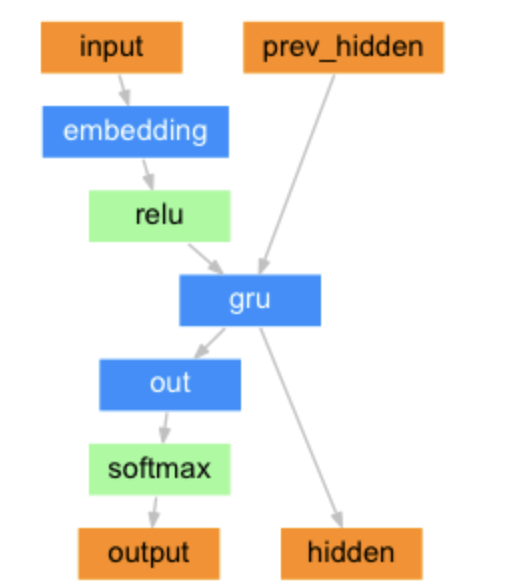

In [5]:
Image("img/decoder.png")

<h3>Training</h3>

In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

실제 training을 거치기 이전에 앞서 준비한 데이터를 tensor로 바꿔주는 과정을 거쳐야한다. <br />
문장으로부터 index를 받아오는 indexesFromSentence함수, 문장을 tensor로 변환하는 tensorFromSentece 함수, <br />
한 개의 영어 문장과 한 개의 프랑스어 문장으로 이루어진 Pair를 input_tensor와 target_tensor로 return 해주는 <br />
tensorsFromPair 함수를 제작한다. 

In [7]:
teacher_forcing_ratio = 1

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden 
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
        
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length
    

'Teacher Forcing' 혹은 '교사 강요'는 input과 Decoder가 예측한 단어가 아닌 실제 정답인 target을 이용해서 학습을 시키는 것을 말한다. <br/> 'Teacher Forcing'을 이용하지 않을 때에는 Decoder가 예측하는 단어를 target으로 설정하여, 학습을 진행시키는 것이다. <br />
'학습'은 적절한 input과 target을 이용하여, 다음에 input을 모델에 주었을 때, 적절한 target을 예측할 수 있게 하는 것이다. <br />
하지만, 교사 강요를 거치지 않고, Decoder가 예측한 단어들을 아직 '정답'이라고 볼 수는 없다. <br />
<br/>
이 코드에서는 teacher_forcing_ratio이라는 변수에 0~1 값을 선언하여, 'Teacher Forcing'을 거치는 비율 또한 설정할 수 있다. <br />
if use_teacher_forcing: 에서는 위에서 설명한대로 loss값을 ouput과 target_tensor로 구하는 것을 볼 수 있다. <br />
else: 에서는 교사 강요를 사용하지 않고 Decoder가 예측한 값을 이용하고자 한다. DecoderRNN 클래스를 보면, Decoder는 output과 hidden state를 매번 return한다.  <br />
.topk()은 가장 큰 element를 반환해주는 함수이다. <br />
<br />
torch.topk documentation: https://pytorch.org/docs/stable/generated/torch.topk.htmltorch.topk는 return 값으로 가장 큰 element의 value와 그 index를 return한다. <br />
즉, decoder_output.topk(1)에서 가장 큰 value를 가진 element 한 개를 내보내는데, <br />
그 element의 value는 topv, 그 index는 topi에 저장한다. 위 과정을 console 창에서 밑과 같이 확인할 수 있다.

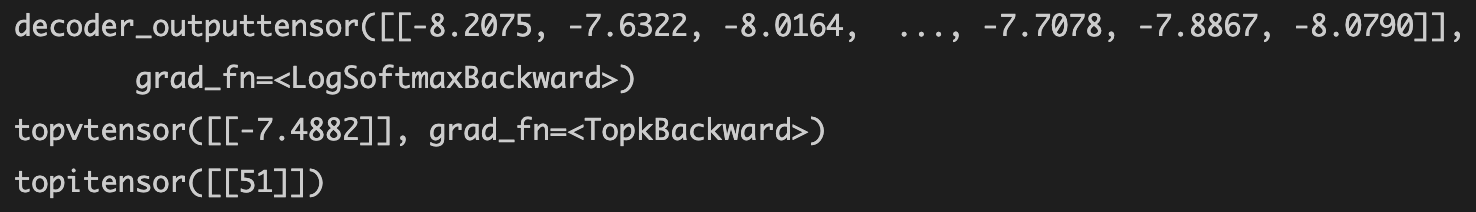

In [8]:
Image("img/topi.png")

In [9]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [10]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1): 
        training_pair = training_pairs[iter-1]
        input_tensor  = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f' % (timeSince(start, iter / n_iters), iter, (iter / n_iters * 100), print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

optimizer로는 SGD를 사용하였고, loss Function으로는 NLLLoss를 사용했다. <br />
학습 중에 진행 과정을 시각화 해주기 위하여, asMinute 함수와 timeSince 함수를 만든다.

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)

이 코드에서 GRU 셀로 만든 Encoder와 Decoder 이용한다. <br />
(이후에는 'Attention'을 추가한 Decoder를 적용해보고자 한다) <br />
Iter 횟수는 75000번, 5000번마다 진행상황을 출력하도록 했다.

<h3>Evaluate</h3>

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        # decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words # decoder_attentions[:di + 1]
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Decoder는 처음에 input으로 SOS와 이전 hidden state인 encoder_hidden을 받는다. <br /> 
그리고, 이전에 설명했던 .topk를 이용하여 다음 단어를 예측한다. topi에 저장되어 있는 다음에 올 확률이 가장  단어의 index로 index2word에서 word를 조회하여 계속해서 문단어를 장에 더해준다. <br /> 
<br />
마지막으로 index로 EOS를 받으면 마지막 문장에 EOS를 append하고 종료한다. <br />
따로 translate라는 함수를 만들어놓았으므로, word2index에 이미 존재하는 word에 한해서, <br />
string 형식으로 프랑스어를 입력한다면, 앞서 만든 모델이 번역한 영어 문장을 받아볼 수 있다. <br />
(Attention 관련한 부분은 일단 주석처리 하였다)

In [ ]:
def translate(sentence):
    output_words = evaluate(encoder1, decoder1, sentence)
    output_sentence = ' '.join(output_words)
    print("input(kor): " + sentence)
    print("output(eng): " + output_sentence + "\n")

그리고, 랜덤한 문장을 번역해 볼 수 있는 translate 함수를 제작했다.

In [ ]:
translate("저는 오늘 시장에 갑니다")
translate("그는 많이 아픕니다")
translate("그녀는 저녁을 먹고 싶습니다")
translate("나는 많은 것을 배울 수 있습니다")
translate("너는 나를 사랑합니다")
translate("저는 방에 누가 있는지 모릅니다")